## 「　Reddit Data　」

**Methodology**:

1. The `submission_id` and `submission_url` were manually inputed from r/wallstreetbets latest daily discussion threads
2. Only keep comments that were posted within market hours because we're interested in intraday trading
3. Combine all the daily CSVs from `data/reddit` into a single CSV

**Note**: Requires Reddit user credentials to be input into `.env`, but running this script is not necessary for running the main program as I've already attached the combined dataset in `data/`

In [1]:
# python version 3.11.6

# %pip install python-dotenv
# %pip install praw
# %pip install dotenv

In [4]:
import os
from dotenv import load_dotenv
from datetime import datetime

load_dotenv()

client_id = os.environ.get("CLIENT_ID")
client_secret = os.environ.get("CLIENT_SECRET")
dev_name = os.environ.get("DEV_NAME")

In [23]:
import pandas as pd
import praw
import time
from prawcore.exceptions import TooManyRequests
from datetime import datetime

reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=f"RedditStream v1 (by /u/{dev_name})")
submission = reddit.subreddit('wallstreetbets')
submission_id = "1pkq67i" 
submission_url = "https://www.reddit.com/r/wallstreetbets/comments/1pkq67i/daily_discussion_thread_for_december_12_2025/"

print(f"--- Starting comment extraction for submission ID: {submission_id} ---")
print(f"URL: {submission_url}\n")


def extract_all_comments(submission_id):
    submission = reddit.submission(id=submission_id)
    
    # We manually handle the 'MoreComments' objects to control the rate
    print("Expanding comment tree (this may take a while)...")
    
    while True:
        try:
            # We use a small limit or None, but wrap it in a retry loop
            submission.comments.replace_more(limit=None)
            break 
        except TooManyRequests as e:
            # If we hit a rate limit, look at how long Reddit wants us to wait
            # Usually 60 seconds is a safe bet if the exception doesn't specify
            retry_after = getattr(e.response, 'headers', {}).get('retry-after', 60)
            print(f"Rate limit hit. Sleeping for {retry_after} seconds...")
            time.sleep(float(retry_after))
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            break

    all_comments = submission.comments.list()
    comments_data = []

    for comment in all_comments:
        # Check if the object is an actual Comment (not a MoreComments object)
        if isinstance(comment, praw.models.Comment):
            author_name = "[deleted]" if not comment.author else comment.author.name
            timestamp_str = datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S')

            comments_data.append({
                "id": comment.id,
                "author": author_name,
                "score": comment.score,
                "created_utc": comment.created_utc,
                "created_datetime": timestamp_str,
                "body": comment.body.replace('\n', ' ')
            })

    return pd.DataFrame(comments_data)

--- Starting comment extraction for submission ID: 1pkq67i ---
URL: https://www.reddit.com/r/wallstreetbets/comments/1pkq67i/daily_discussion_thread_for_december_12_2025/



In [24]:
# ~16-30 minute run time for 10k comments
df_comments = extract_all_comments(submission_id)
df_comments.to_csv(f"data/reddit_comments_{submission_id}.csv", index=False)

Expanding comment tree (this may take a while)...
Rate limit hit. Sleeping for 60 seconds...


### Disaggregate based on hour

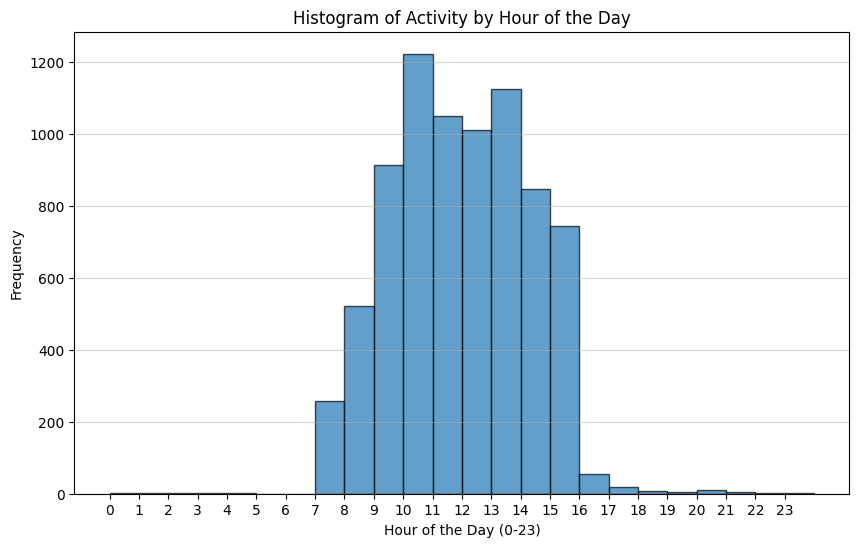

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

df_comments['created_datetime'] = pd.to_datetime(df_comments['created_datetime'])
hours = df_comments['created_datetime'].dt.hour
plt.figure(figsize=(10, 6))
plt.hist(hours, bins=24, range=(0, 24), edgecolor='black', alpha=0.7)
plt.title('Histogram of Activity by Hour of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))  # Show all hour ticks
plt.grid(axis='y', alpha=0.5)

plt.show()

### Merge multiple datasets

In [25]:
import glob
import os
import pandas as pd

input_dir = 'data/reddit'

all_files = glob.glob(os.path.join(input_dir, "*.csv"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [26]:
df

,id,author,score,created_utc,created_datetime,body
0,nta44jr,MrYOLOMcSwagMeister,118,1.765371e+09,2025-12-10 07:43:51,If my brain wasn't full of microplastics I wou...
1,nta1uol,kal14144,103,1.765370e+09,2025-12-10 07:27:33,Last FOMC meeting with an independent fed. Cheers
2,nta6wie,BFox1982,49,1.765372e+09,2025-12-10 08:02:36,"If lowering rates 50 basis points is good, ima..."
3,ntbz7fe,OSRSkarma,130,1.765392e+09,2025-12-10 13:37:51,Rate decision: FED CUTS KEY INTEREST RATE BY 2...
4,nt9ztox,jackedup13,40,1.765369e+09,2025-12-10 07:12:15,Already made $6 today. See you at Wendy’s losers.
...,...,...,...,...,...,...
184536,nt5v2nj,TreGet234,1,1.765309e+09,2025-12-09 14:28:57,I fully agree but why silver over gold?
184537,nt4sr51,092Casey,2,1.765297e+09,2025-12-09 11:16:05,Lol 😆 JP. Good strategy. I actually am scalp...
184538,nthuup3,billyd1984texas,1,1.765473e+09,2025-12-11 12:10:50,Told ya
184539,nt6a5zi,selfemployedsince16,1,1.765313e+09,2025-12-09 15:43:41,Per oz gold went from 80-1trillion marks to I’...


### Pre-processing data schema

In [27]:
df['created_datetime'] = pd.to_datetime(df['created_datetime'], format='mixed')
is_weekday = (df['created_datetime'].dt.dayofweek >= 0) & (df['created_datetime'].dt.dayofweek <= 4)    # Weekdays
is_after_open = (df['created_datetime'].dt.hour > 9) | ((df['created_datetime'].dt.hour == 9) & (df['created_datetime'].dt.minute >= 30))   # After market open
is_before_close = (df['created_datetime'].dt.hour < 16) | ((df['created_datetime'].dt.hour == 16) & (df['created_datetime'].dt.minute == 0))    # Before market close
cdf = df[is_weekday & is_after_open & is_before_close].reset_index(drop=True)    # Filter

In [28]:
cdf

,id,author,score,created_utc,created_datetime,body
0,ntbz7fe,OSRSkarma,130,1.765392e+09,2025-12-10 13:37:51,Rate decision: FED CUTS KEY INTEREST RATE BY 2...
1,ntb441h,Mr-Bonnet,29,1.765383e+09,2025-12-10 11:06:13,MM CANT PUMP BECAUSE I HAVE CALLS MM CANT DU...
2,ntcdoud,wildcat1055,27,1.765396e+09,2025-12-10 14:48:42,**JPow**: we'll follow the data **Also JPow**...
3,ntao4ek,31andnotdone,22,1.765378e+09,2025-12-10 09:44:27,good luck today boys mommy believes in you.
4,ntar777,NeedleworkerOne8258,24,1.765379e+09,2025-12-10 10:00:54,https://preview.redd.it/v9y32hbp5e6g1.jpeg?wid...
...,...,...,...,...,...,...
148079,nt5v2nj,TreGet234,1,1.765309e+09,2025-12-09 14:28:57,I fully agree but why silver over gold?
148080,nt4sr51,092Casey,2,1.765297e+09,2025-12-09 11:16:05,Lol 😆 JP. Good strategy. I actually am scalp...
148081,nthuup3,billyd1984texas,1,1.765473e+09,2025-12-11 12:10:50,Told ya
148082,nt6a5zi,selfemployedsince16,1,1.765313e+09,2025-12-09 15:43:41,Per oz gold went from 80-1trillion marks to I’...


In [29]:
cdf.rename(columns={"created_datetime": "datetime", "body": "text"}, inplace=True)
cdf = cdf[['datetime', 'score', 'text']]

In [30]:
cdf.to_csv("data/full_manual_wsb.csv", index=False)